In [1]:
import cv2
import mediapipe as mp
import numpy as np
import time
from IPython.display import display, Image, clear_output

def video_show(frame, width=400, height=400):
    _, buffer = cv2.imencode(".jpg", frame)
    clear_output(wait=True)
    display(Image(data=buffer, width=width, height=height))

2025-04-03 14:37:05.725383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743658625.820235  111523 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743658625.848928  111523 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743658626.073851  111523 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743658626.073872  111523 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743658626.073873  111523 computation_placer.cc:177] computation placer alr

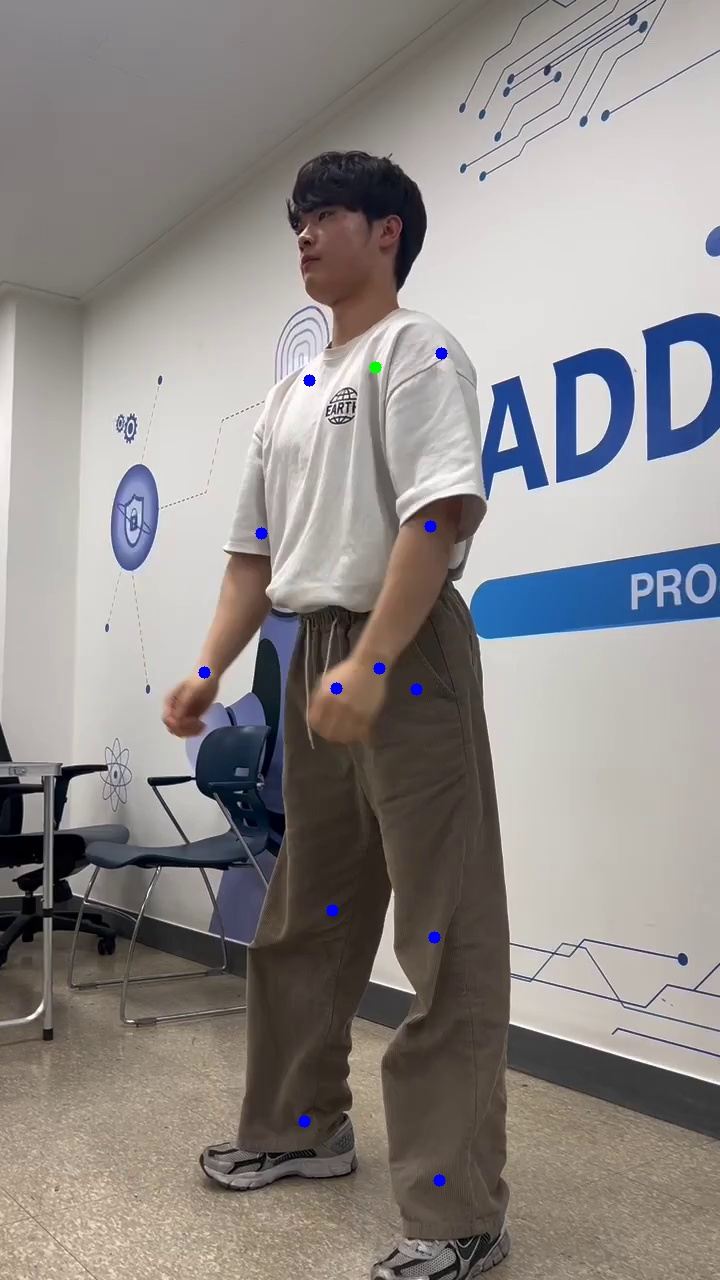

In [ ]:
class AngleGuid():
    def __init__(self, exercise):
        self.vectors = {0: None, 1: None}
        self.initialized = {0: False, 1: False}
        self.count = 0

        self.r = (0, 0, 255)
        self.g = (0, 255, 0)
        self.b = (255, 0, 0)

        self.exercise = exercise

        self.state = {0: "up", 1: "up"}

    def initialize(self):
        if self.exercise == "squat":
            self.squat_init()
        elif self.exercise == "shoulder":
            self.shoulder_press_init()
        elif self.exercise == "knee":
            self.knee_raise_init()
    
    def squat_init(self):
        self.up_angle = 160
        self.down_angle = 50

    def shoulder_press_init(self):
        self.up_angle = 130
        self.down_angle = 40

    def knee_raise_init(self):
        self.up_angle = 40
        self.down_angle = 160
        self.knee_state = {0: 0, 1: 0}

    def update(self, index, angle, passing):
        if passing: return

        if self.exercise == "shoulder":
            if self.state[index] == "up" and angle > self.up_angle:
                self.state[index] = "down"

                if self.state[0] == "down" and self.state[1] == "down":
                    self.count +=1
            elif self.state[index] == "down":
                if angle < self.down_angle:
                    self.state[index] = "up"
        elif self.exercise == "squat":
            if self.state[index] == "down" and angle < self.down_angle:
                self.state[index] = "up"

                if self.state[0] == "up" and self.state[1] == "up":
                    self.count += 1
            elif self.state[index] == "up" and angle > self.up_angle:
                self.state[index] = "down"
        elif self.exercise == "knee":
            if self.state[index] == "up" and angle < self.up_angle:
                    self.state[index] = "down"
                    self.count += 0.5
            elif self.state[index] == "down" and angle > self.down_angle:
                    self.state[index] = "up"

    def to_pixel(self, frame, idx, landmarks):
        return np.array([
            landmarks[idx].x * frame.shape[1],
            landmarks[idx].y * frame.shape[0]
        ], dtype=np.float32)

    def calculate_angle(self, a, b, c):
        a = np.array([a.x, a.y])
        b = np.array([b.x, b.y])
        c = np.array([c.x, c.y])
        ba = a - b
        bc = c - b
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
        angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
        return np.degrees(angle)
    
    def get_point_by_angle(self, origin, center, from_point, angle_deg, length=None):
        """
        center: 기준점 (어깨)
        from_point: 시작점 (팔꿈치)
        angle_deg: 기준 벡터에서 몇 도 떨어진 위치인지
        length: 벡터 길이 (None이면 기존 길이 유지)
        """
        vec = from_point - center
        if length is None:
            length = np.linalg.norm(vec)

        # 단위 벡터
        unit_vec = vec / (np.linalg.norm(vec) + 1e-6)

        # 회전 각도: 관절 기준이라 180도에서 빼야 함
        theta = np.radians(180 - angle_deg)

        rot_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ])

        rotated_vec = rot_matrix @ unit_vec
        target_point = origin + rotated_vec * length
        return target_point



    def draw_shoulder_press_line(self, frame, landmarks):
        # 어깨, 팔꿈치, 손목
        joints = [
            (12, 14, 16),
            (11, 13, 15)
        ]

        for idx, (a, b, c) in enumerate(joints):
            passing = False
            shoulder = self.to_pixel(frame, a, landmarks)
            elbow = self.to_pixel(frame, b, landmarks)     # 발목
            wrist = self.to_pixel(frame, c, landmarks)    # 무릎
            length = np.linalg.norm(shoulder-wrist)

            abs_ = 1 if idx == 0 else -1

            if not self.initialized[idx]:
                self.vectors[idx] = self.get_point_by_angle(shoulder, elbow, shoulder, abs_ * -120, 100)
                    
                self.initialized[idx] = True

            angle = self.calculate_angle(landmarks[a], landmarks[b], landmarks[c])
            if wrist[1] > shoulder[1]:
                passing = True
                
            self.update(idx, angle, passing)

            color = self.g if angle > self.up_angle else self.r

            # 가이드라인 그리기
            cv2.line(frame, tuple(shoulder.astype(int)), tuple(self.vectors[idx].astype(int)), self.g, 2)
            # 팔 라인 그리기
            cv2.line(frame, tuple(shoulder.astype(int)), tuple(elbow.astype(int)), color, 2)
            cv2.line(frame, tuple(elbow.astype(int)), tuple(wrist.astype(int)), color, 2)

            # 관절 포인트 그리기
            cv2.circle(frame, tuple(shoulder.astype(int)), 4, self.b, -1)
            cv2.circle(frame, tuple(elbow.astype(int)), 4, self.b, -1)
            cv2.circle(frame, tuple(wrist.astype(int)), 4, self.b, -1)

            cv2.putText(frame, str(int(angle)), (int(elbow[0]), int(elbow[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    def draw_squat_line(self, frame, landmarks):
        # 골반, 무릎, 발목
        joints = [
            (24, 26, 28),
            (23, 25, 27)
        ]

        cv2.circle(frame, tuple(self.to_pixel(frame, 11, landmarks).astype(int)), 6, (255, 0, 0), -1)
        cv2.circle(frame, tuple(self.to_pixel(frame, 12, landmarks).astype(int)), 6, (255, 0, 0), -1)
        cv2.circle(frame, tuple(self.to_pixel(frame, 13, landmarks).astype(int)), 6, (255, 0, 0), -1)
        cv2.circle(frame, tuple(self.to_pixel(frame, 14, landmarks).astype(int)), 6, (255, 0, 0), -1)
        cv2.circle(frame, tuple(self.to_pixel(frame, 15, landmarks).astype(int)), 6, (255, 0, 0), -1)
        cv2.circle(frame, tuple(self.to_pixel(frame, 16, landmarks).astype(int)), 6, (255, 0, 0), -1)
        cv2.circle(frame, tuple(self.to_pixel(frame, 23, landmarks).astype(int)), 6, (255, 0, 0), -1)
        cv2.circle(frame, tuple(self.to_pixel(frame, 24, landmarks).astype(int)), 6, (255, 0, 0), -1)
        cv2.circle(frame, tuple(self.to_pixel(frame, 25, landmarks).astype(int)), 6, (255, 0, 0), -1)
        cv2.circle(frame, tuple(self.to_pixel(frame, 26, landmarks).astype(int)), 6, (255, 0, 0), -1)
        cv2.circle(frame, tuple(self.to_pixel(frame, 27, landmarks).astype(int)), 6, (255, 0, 0), -1)
        cv2.circle(frame, tuple(self.to_pixel(frame, 28, landmarks).astype(int)), 6, (255, 0, 0), -1)

        for idx, (a, b, c) in enumerate(joints):
            hip = self.to_pixel(frame, a, landmarks)
            ankle = self.to_pixel(frame, c, landmarks)
            knee = self.to_pixel(frame, b, landmarks)
            length = np.linalg.norm(ankle-knee)
            
            abs_ = -1 if idx == 0 else 1

            if not self.initialized[idx]:
                self.vectors[idx] = self.get_point_by_angle(knee, knee, ankle, abs_ * 120)

                self.initialized[idx] = True

            # 가이드라인 그리기
            # cv2.line(frame, tuple(knee.astype(int)), tuple(self.vectors[idx].astype(int)), (0, 255, 0), 2)

            angle = self.calculate_angle(landmarks[a], landmarks[b], landmarks[c])
            self.update(idx, angle, False)

            color = self.r if angle > self.down_angle else self.g

            # 다리 관절 라인 그리기
            # cv2.line(frame, tuple(hip.astype(int)), tuple(knee.astype(int)), color, 2)
            # cv2.line(frame, tuple(knee.astype(int)), tuple(ankle.astype(int)), color, 2)

            # 관절 포인트 그리기
            cv2.circle(frame, tuple(hip.astype(int)), 4, (255, 0, 0), -1)
            cv2.circle(frame, tuple(knee.astype(int)), 4, (255, 0, 0), -1)
            cv2.circle(frame, tuple(ankle.astype(int)), 4, (255, 0, 0), -1)

            # cv2.putText(frame, str(int(angle)), (int(knee[0]), int(knee[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    def draw_knee_raise_line(self, frame, landmarks):
        # 골반, 무릎, 발목
        joints = [
            (24, 26, 28),
            (23, 25, 27)
        ]

        for idx, (a, b, c) in enumerate(joints):
            passing = False
            hip = self.to_pixel(frame, a, landmarks)
            knee = self.to_pixel(frame, b, landmarks)
            ankle = self.to_pixel(frame, c, landmarks)
            length = np.linalg.norm(ankle-knee)

            if not self.initialized[idx]:
                self.vectors[idx] = self.get_point_by_angle(hip, knee, hip, -120, length)
                self.initialized[idx] = True
            
            # 가이드 라인 그리기
            cv2.line(frame, tuple(hip.astype(int)), tuple(self.vectors[idx].astype(int)), (0, 255, 0), 2)

            angle = self.calculate_angle(landmarks[a], landmarks[b], landmarks[c])
            self.update(idx, angle, passing)

            color = self.g if angle < self.up_angle else self.r

            # 관절 라인 그리기
            cv2.line(frame, tuple(hip.astype(int)), tuple(knee.astype(int)), color, 2)
            cv2.line(frame, tuple(knee.astype(int)), tuple(ankle.astype(int)), color, 2)


            # 관절 포인트 그리기
            cv2.circle(frame, tuple(hip.astype(int)), 4, self.b, -1)
            cv2.circle(frame, tuple(knee.astype(int)), 4, self.b, -1)
            cv2.circle(frame, tuple(ankle.astype(int)), 4, self.b, -1)

            # cv2.putText(frame, str(int(angle)), (int(knee[0]), int(knee[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

def video_pose_estimation(video_path, exercise):
    guid = AngleGuid(exercise)
    guid.initialize()

    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    cap = cv2.VideoCapture(video_path)
    pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

    points = [
        11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28
    ]
    try:
        while True:
            ret, frame = cap.read()
            if not ret: break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(image)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            if results.pose_landmarks is None: continue

            lm = results.pose_landmarks.landmark            

            if exercise == "shoulder":
                guid.draw_shoulder_press_line(image, lm)
            elif exercise == "squat":
                guid.draw_squat_line(image, lm)
            elif exercise == "knee":
                guid.draw_knee_raise_line(image, lm)

            # 기준점
            neck_x = (lm[11].x + lm[12].x) / 2
            neck_y = (lm[11].y + lm[12].y) / 2
            
            for idx in points:
                x = lm[idx].x - neck_x
                y = lm[idx].y - neck_y
                
                text_x = int(lm[idx].x * image.shape[1])
                text_y = int(lm[idx].y * image.shape[0])

                if idx % 2 == 0:
                    offset = -300
                else:
                    offset = 10

                # cv2.putText(image, f"x:{round(x, 3)}, y:{round(y, 3)}", (text_x + offset, text_y + 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            cv2.circle(image, (int(neck_x * image.shape[1]), int(neck_y * image.shape[0])), 6, (0,255,0), -1)
            # cv2.putText(image, f"{int(guid.count)}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 10, cv2.LINE_AA)
            # cv2.putText(image, f"left : {guid.state[0]}", (10, 170), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 10, cv2.LINE_AA)
            # cv2.putText(image, f"right : {guid.state[1]}", (10, 270), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 10, cv2.LINE_AA)
            # print(f"{guid.count} left : {guid.state[0]}, right : {guid.state[1]}     ", end='\r')
            #mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
            # video_show(image, width=320, height=320)
            cv2.imshow("frame", image)

            if cv2.waitKey(1) == ord('q'):
                break
    finally:
        pose.close()
        cap.release()
        cv2.destroyAllWindows()

video_name = "13"
path = "/home/shin/deeplearning-repo-1/dataset/squat/" + video_name + ".mp4"
video_pose_estimation(0, "squat")

In [ ]:
video_name = "12"
path = "/home/shin/deeplearning-repo-1/dataset/squat/" + video_name + ".mp4"
video_pose_estimation(path, "squat")